# Bayesian A/B Testing

In [1]:
import sys
print(sys.executable)
print(sys.version)

/Users/kazutak/Git/AB_test/.venv/bin/python
3.9.9 (main, Apr 22 2023, 13:11:31) 
[Clang 14.0.0 (clang-1400.0.29.202)]


In [2]:
import numpy as np
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

## 問題設定

Q. Alice と Bob のレポートは、どっちが信頼できる結果？

| Alice のレポート | Aパターン | Bパターン |
| :--- | :--: | :--: |
| UU | 40 | 50 |
| CV | 2 | 4 |
| UU CVR | 5% | 8% |

| Bob のレポート | Aパターン | Bパターン |
| :--- | :--: | :--: |
| UU | 1280 | 1600 |
| CV | 64 | 128 |
| UU CVR | 5% | 8% |

## 表記
+ $ \theta $ : その群固有のCV率（本来は連続値だが、離散範囲を細かく切って表現）`thetas`
+ $ r $ : CVあり = 1、 CVなし = 0 `r`
+ $ p(\theta) $ : データを観測する前の $\theta$ の事前分布、信念 `p`
+ $ p(\theta | D) $ : データを観測した後の $\theta$ の事後分布、信念 `p`
+ 事前分布：一様分布を前提とし、`r` によって更新されるよう関数定義 `posterior(r, prior)`

In [3]:
thetas = np.linspace(0, 1, 1001)

likelihood = lambda r: thetas if r else (1 - thetas)

def posterior(r, prior):
    lp = likelihood(r) * prior
    return lp / lp.sum()

In [4]:
# 一様分布を前提として、thetas の要素数で均等に値を分けてリスト化（確率の前提より 合計 = 1）
p = np.array([1 / len(thetas) for _ in thetas])

## 信念 $p$ をベイズ更新

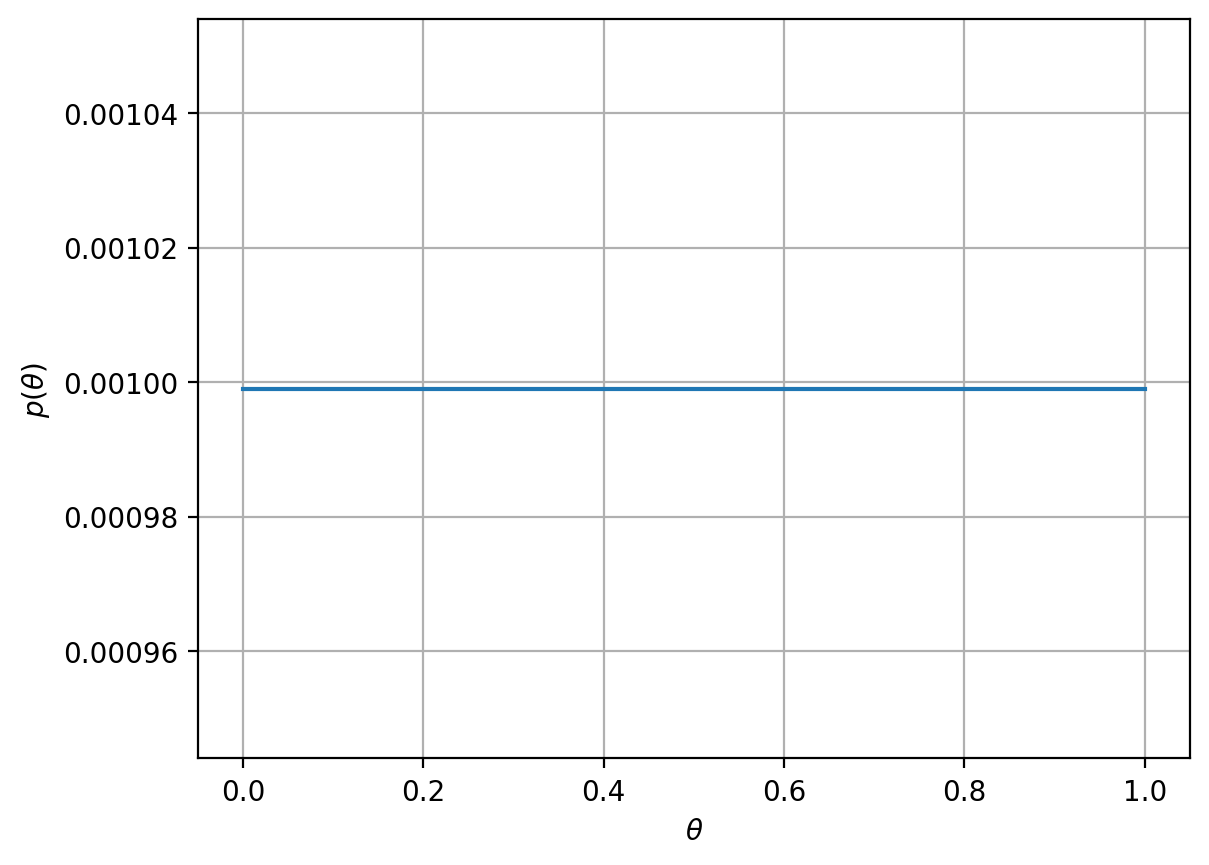

In [5]:
# 初期値
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.grid()
plt.show()

In [6]:
# 一度だけベイズ更新をしてみる
p_1 = posterior(1, p)

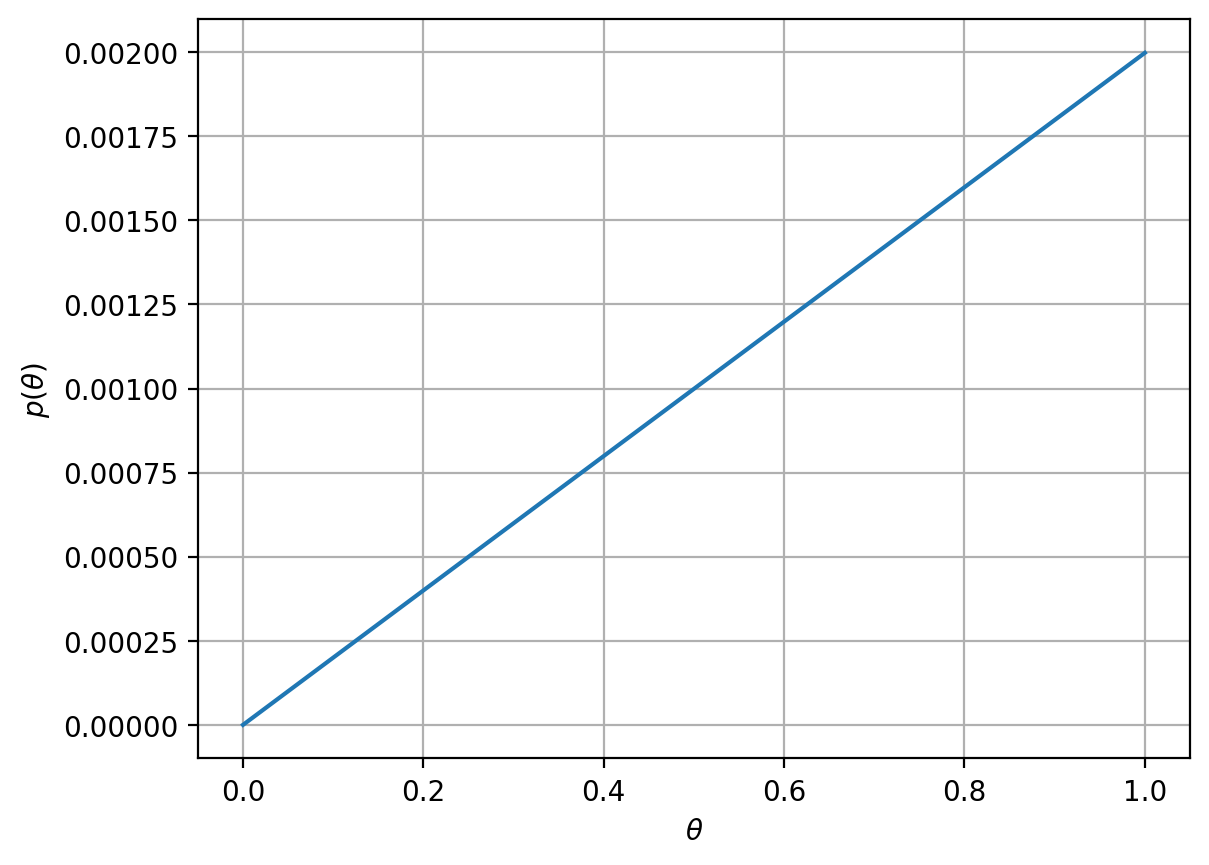

In [7]:
# 初期値
plt.plot(thetas, p_1)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.grid()
plt.show()

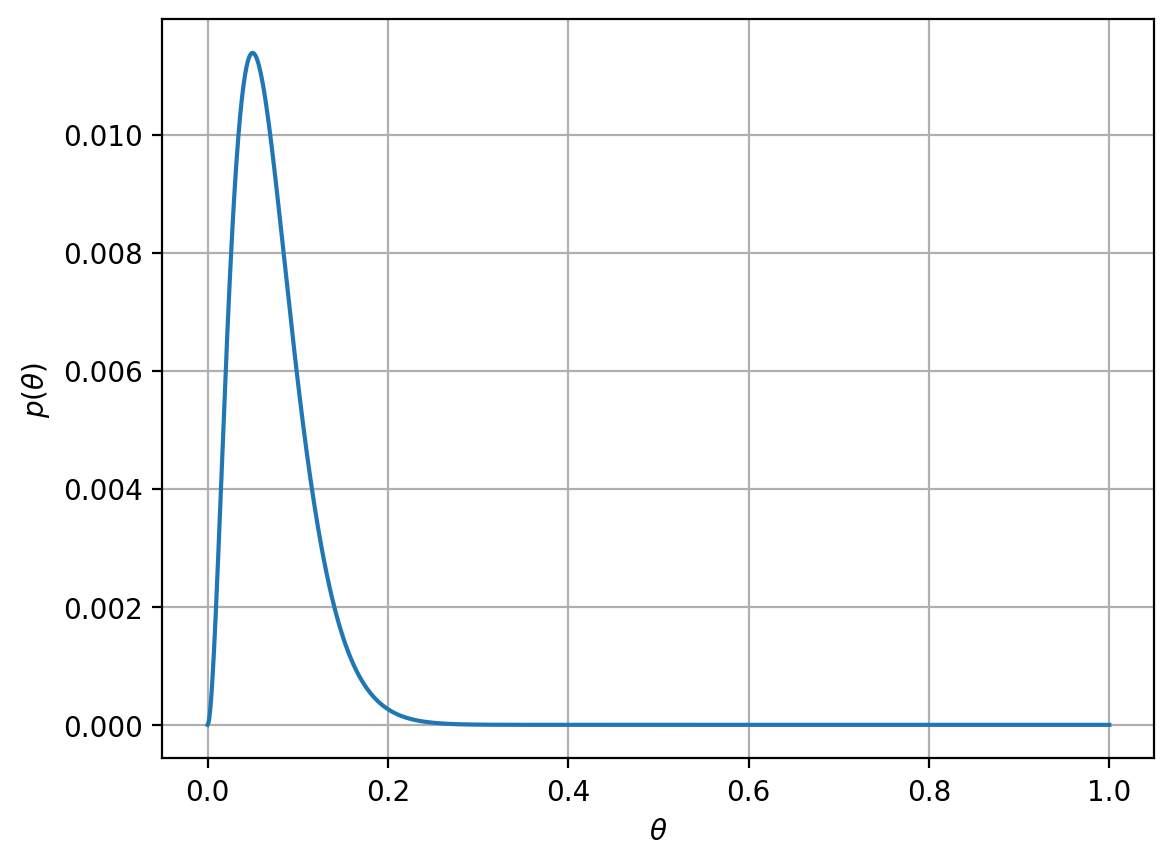

In [8]:
# Alice のレポート Aパターン にあるCV数、非CV数を元に”信念”をベイズ更新してみる
cv_cnt = 2
non_cv_cnt = 38

# 一様分布を前提として、thetas の要素数で均等に値を分けてリスト化（確率の前提より 合計 = 1）
p = np.array([1 / len(thetas) for _ in thetas])
for _ in range(cv_cnt):
    p = posterior(1, p)
for _ in range(non_cv_cnt):
    p = posterior(0, p)
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.grid()
plt.show()

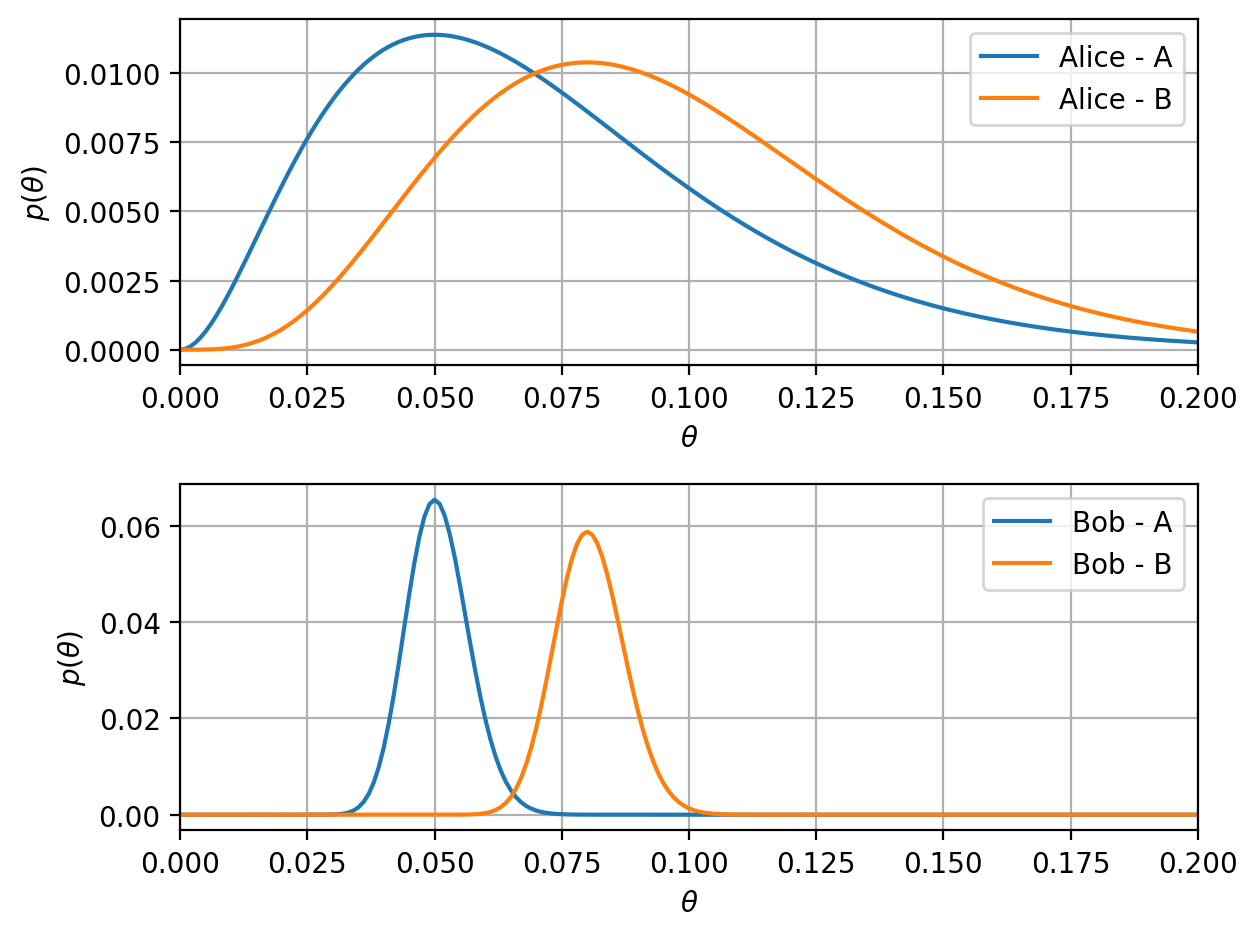

In [9]:
def draw(cv_cnt, non_cv_cnt, label):
  p = np.array([1 / len(thetas) for theta in thetas])
  for _ in range(cv_cnt):
    p = posterior(1, p)
  for _ in range(non_cv_cnt):
    p = posterior(0, p)
  plt.plot(thetas, p, label = label)
  
plt.subplot(2, 1, 1)
draw(2, 40 - 2, 'Alice - A')
draw(4, 50 - 4, 'Alice - B')
plt.xlim(0, 0.2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
draw(64, 1280 - 64, 'Bob - A')
draw(128, 1600 - 128, 'Bob - B')
plt.xlim(0, 0.2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 別解：繰り返しをまとめる

ベルヌーイ分布を仮定してCVするかどうかをUU毎にベイズ更新するのは大変そうなので、まとめて二項分布を想定した書き方に変換する<br>
レポートに記された数字（$a$ = True回数、$N$ = 試行回数）を直接利用して推論するという意味ではよりエレガントな解法といえる。

In [10]:
likelihood = lambda a, N: thetas ** a * (1 - thetas) ** (N - a)

In [11]:
def posterior(a, N, prior):
  lp = likelihood(a, N) * prior
  return lp / lp.sum()

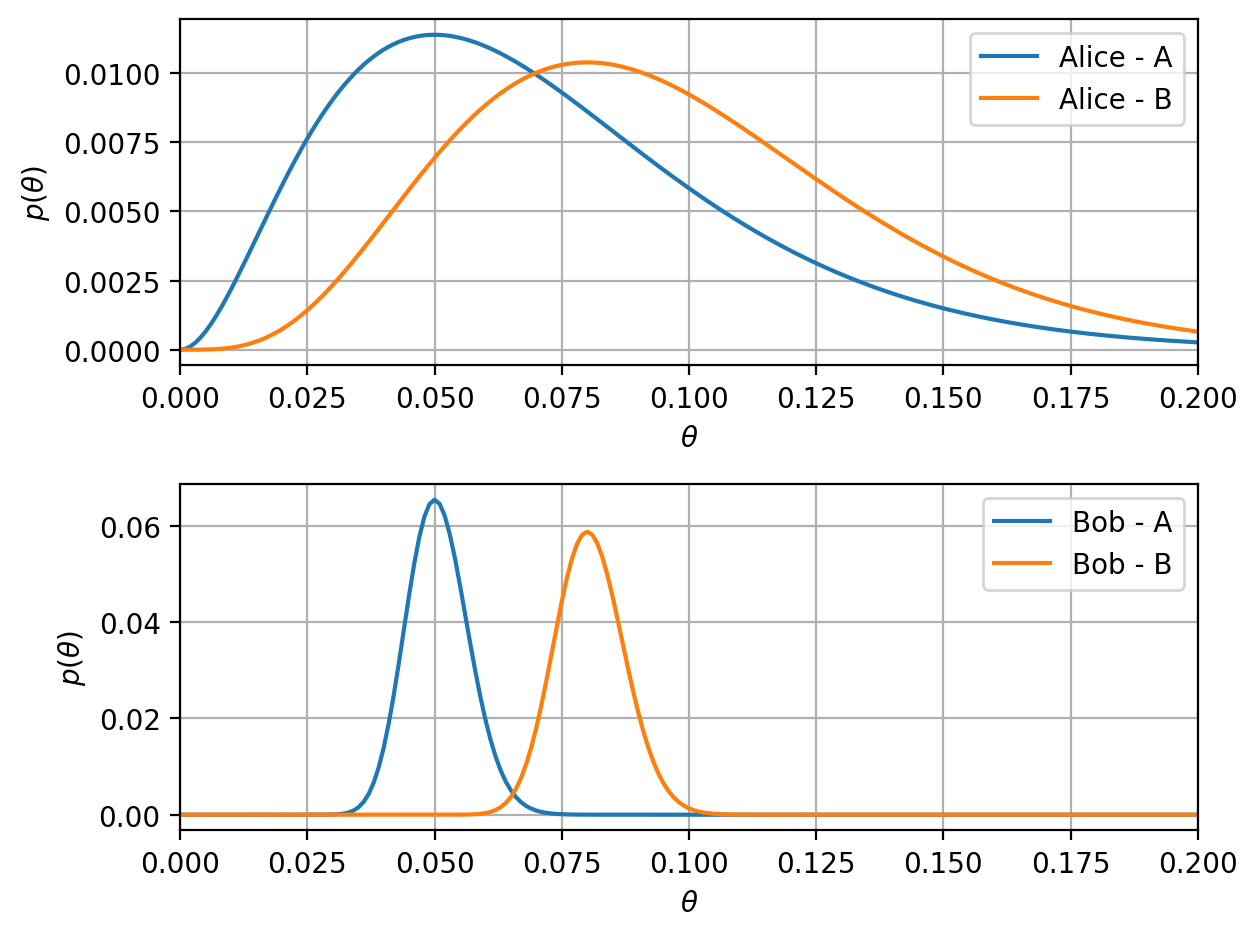

In [12]:
prior = 1 / len(thetas)
plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40, prior), label='Alice - A')
plt.plot(thetas, posterior(4, 50, prior), label='Alice - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280, prior), label='Bob - A')
plt.plot(thetas, posterior(128, 1600, prior), label='Bob - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## 別解：繰り返しをまとめる(ベータ分布)

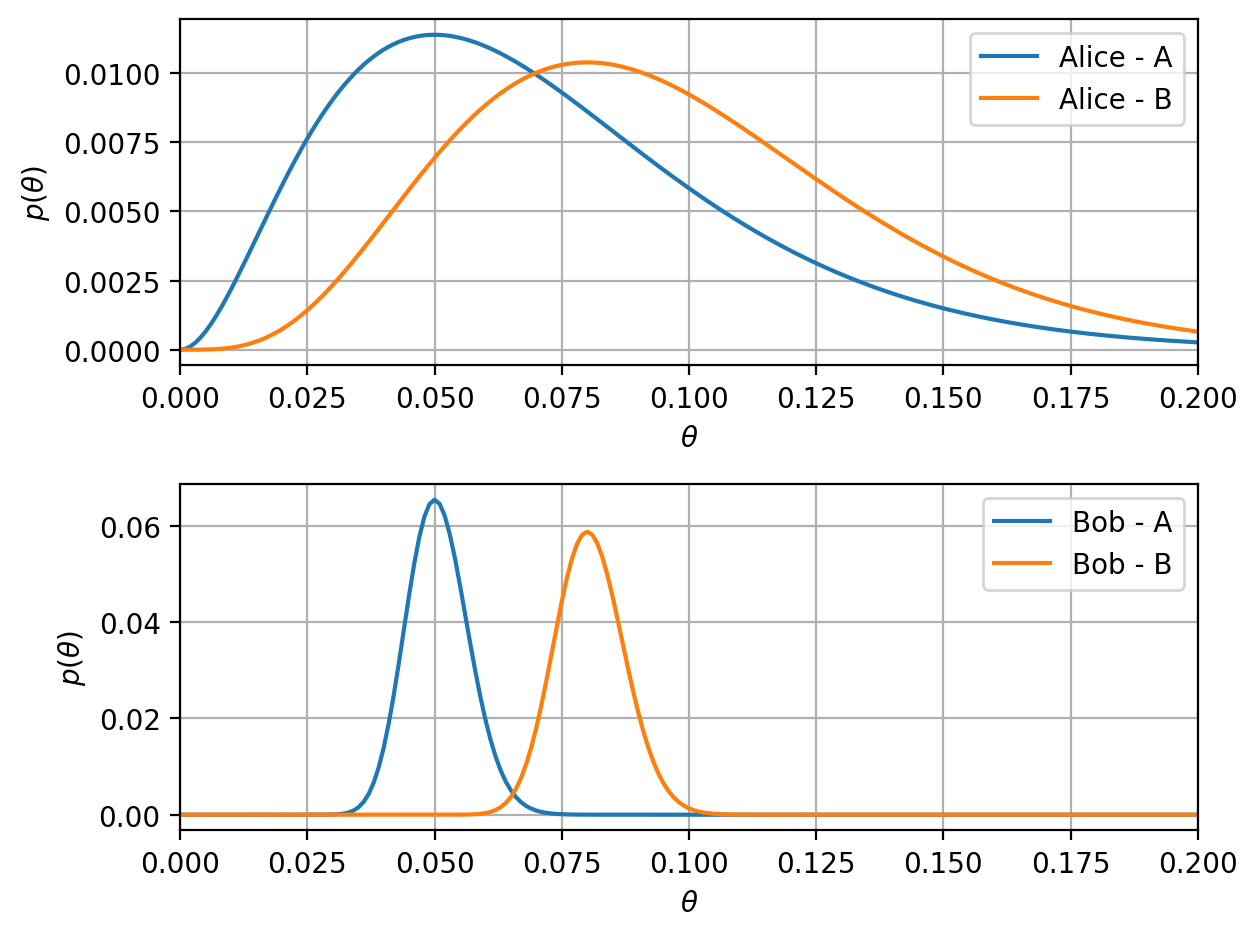

In [15]:
def betaf(alpha, beta):
  numerator = thetas ** (alpha - 1) * (1 - thetas) ** (beta - 1)
  return numerator / numerator.sum()

def posterior(a, N):
  return betaf(a + 1, N - a + 1)

plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40), label='Alice - A')
plt.plot(thetas, posterior(4, 50), label='Alice - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280), label='Bob - A')
plt.plot(thetas, posterior(128, 1600), label='Bob - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## HDI

In [16]:
def hmv(xs, ps, alpha=0.95):
  xps = sorted(zip(xs, ps), key=lambda xp: xp[1], reverse=True)
  xps = np.array(xps)
  xs = xps[:, 0]
  ps = xps[:, 1]
  return np.sort(xs[np.cumsum(ps) <= alpha])

In [17]:
thetas = np.linspace(0, 1, 1001)

def posterior(a, N):
  alpha = a + 1
  beta = N - a + 1
  numerator = thetas ** (alpha - 1) * (1 - thetas) ** (beta - 1)
  return numerator / numerator.sum()

ps = posterior(2, 40)

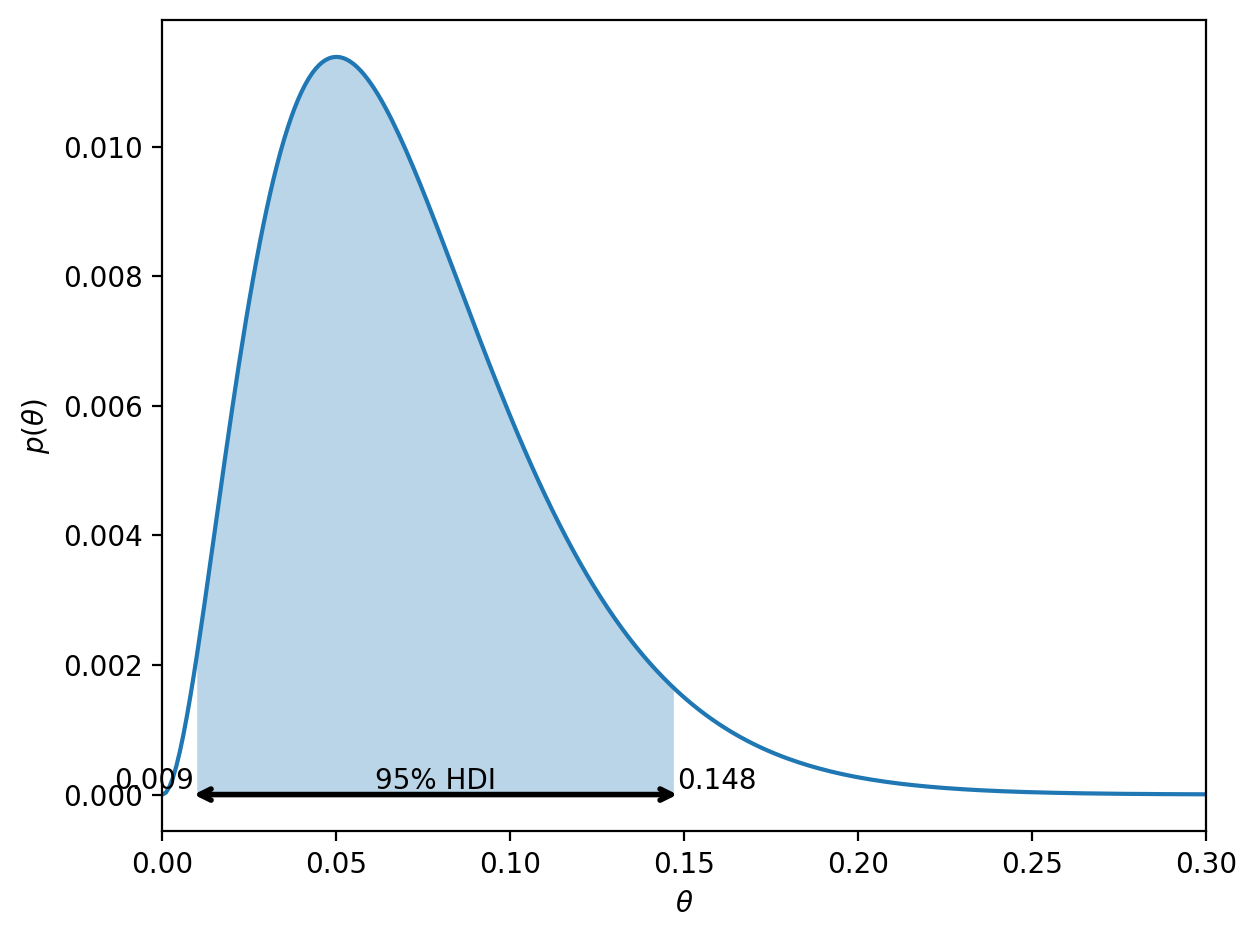

In [18]:
hm_thetas = hmv(thetas, ps, alpha=0.95)
plt.plot(thetas, ps)
plt.annotate('', xy=(hm_thetas.min(), 0),
              xytext=(hm_thetas.max(), 0),
              arrowprops=dict(color='black', shrinkA=0, shrinkB=0,
                              arrowstyle='<->', linewidth=2))
plt.annotate('%.3f' % hm_thetas.min(), xy=(hm_thetas.min(), 0),
              ha='right', va='bottom')
plt.annotate('%.3f' % hm_thetas.max(), xy=(hm_thetas.max(), 0),
              ha='left', va='bottom')
plt.annotate('95% HDI', xy=(hm_thetas.mean(), 0),
              ha='center', va='bottom')
hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.3)
plt.tight_layout()
plt.show()

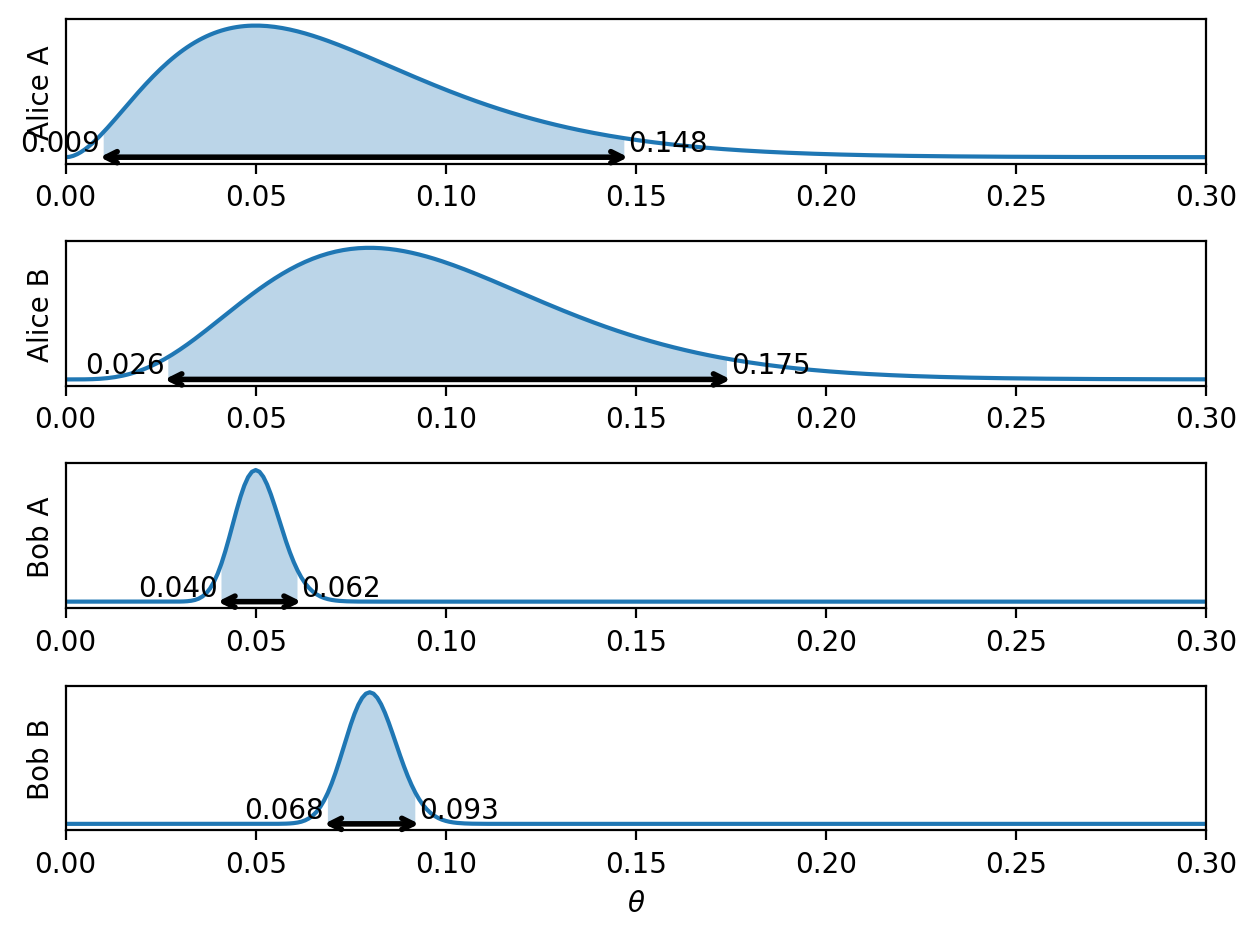

In [19]:
def plot_hdi(ps, label):
  hm_thetas = hmv(thetas, ps, 0.95)
  plt.plot(thetas, ps)
  plt.annotate('', xy=(hm_thetas.min(), 0),
                xytext=(hm_thetas.max(), 0),
                arrowprops=dict(color='black', shrinkA=0, shrinkB=0,
                                arrowstyle='<->', linewidth=2))
  plt.annotate('%.3f' % hm_thetas.min(), xy=(hm_thetas.min(), 0),
                ha='right', va='bottom')
  plt.annotate('%.3f' % hm_thetas.max(), xy=(hm_thetas.max(), 0),
                ha='left', va='bottom')
  hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
  plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
  plt.xlim(0, 0.3)
  plt.ylabel(label)
  plt.yticks([])

plt.subplot(4, 1, 1)
alice_a = posterior(2, 40)
plot_hdi(alice_a, 'Alice A')
plt.subplot(4, 1, 2)
alice_b = posterior(4, 50)
plot_hdi(alice_b, 'Alice B')
plt.subplot(4, 1, 3)
bob_a = posterior(64, 1280)
plot_hdi(bob_a, 'Bob A')
plt.subplot(4, 1, 4)
bob_b = posterior(128, 1600)
plot_hdi(bob_b, 'Bob B')
plt.xlabel(r'$\theta$')
plt.tight_layout()
plt.show()

## 事後分布から新たな確率変数を獲得する（判断指標）

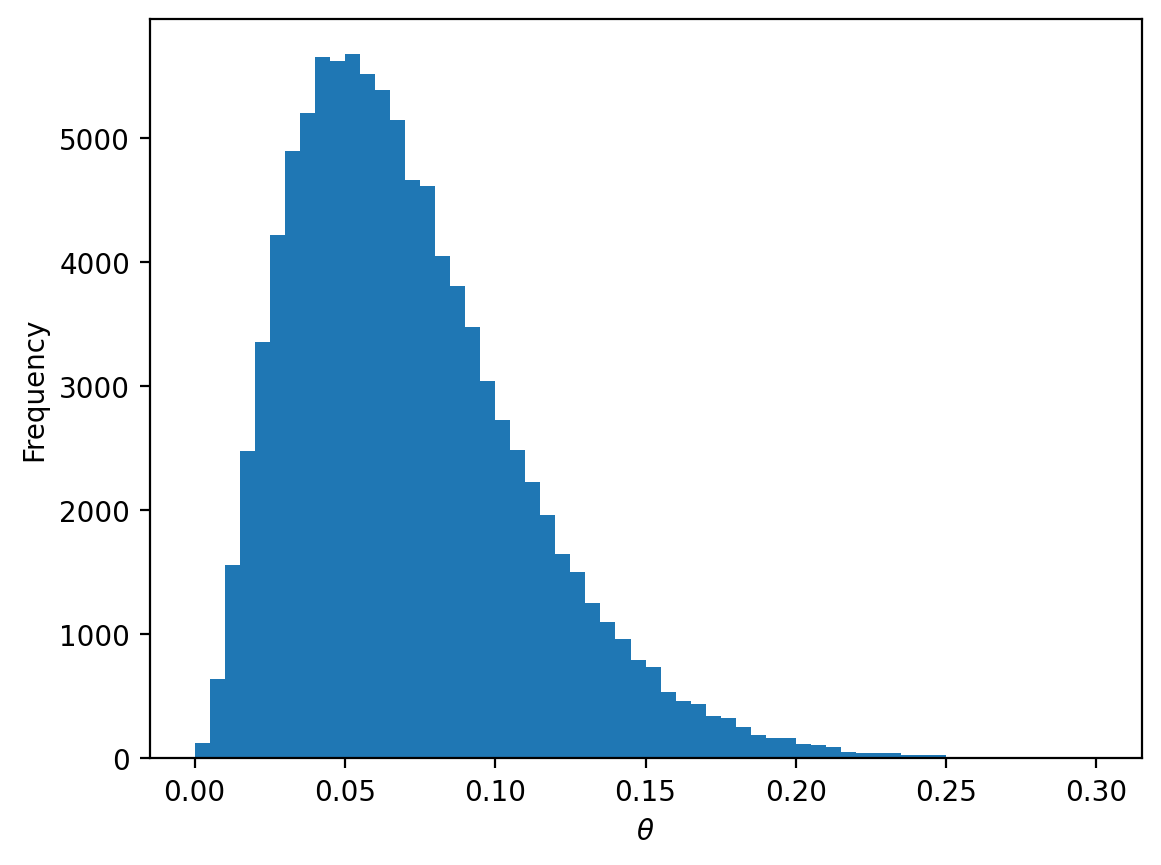

In [28]:
data = np.random.beta(3, 39, size=100000)
plt.hist(data, range=(0, 0.3), bins=60)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

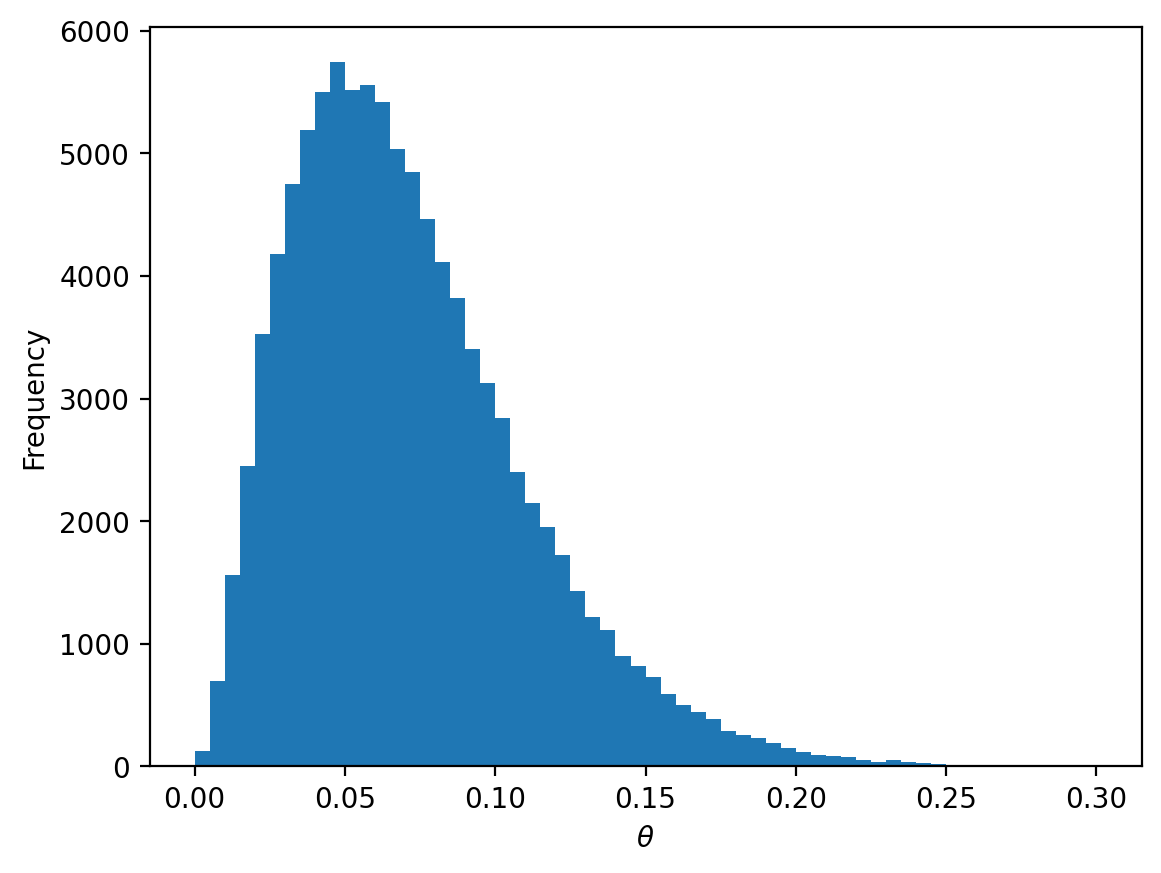

In [29]:
data = np.random.beta(3, 39, size=100000)
plt.hist(data, range=(0, 0.3), bins=60)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

In [30]:
print((delta > 0).mean())

0.99926


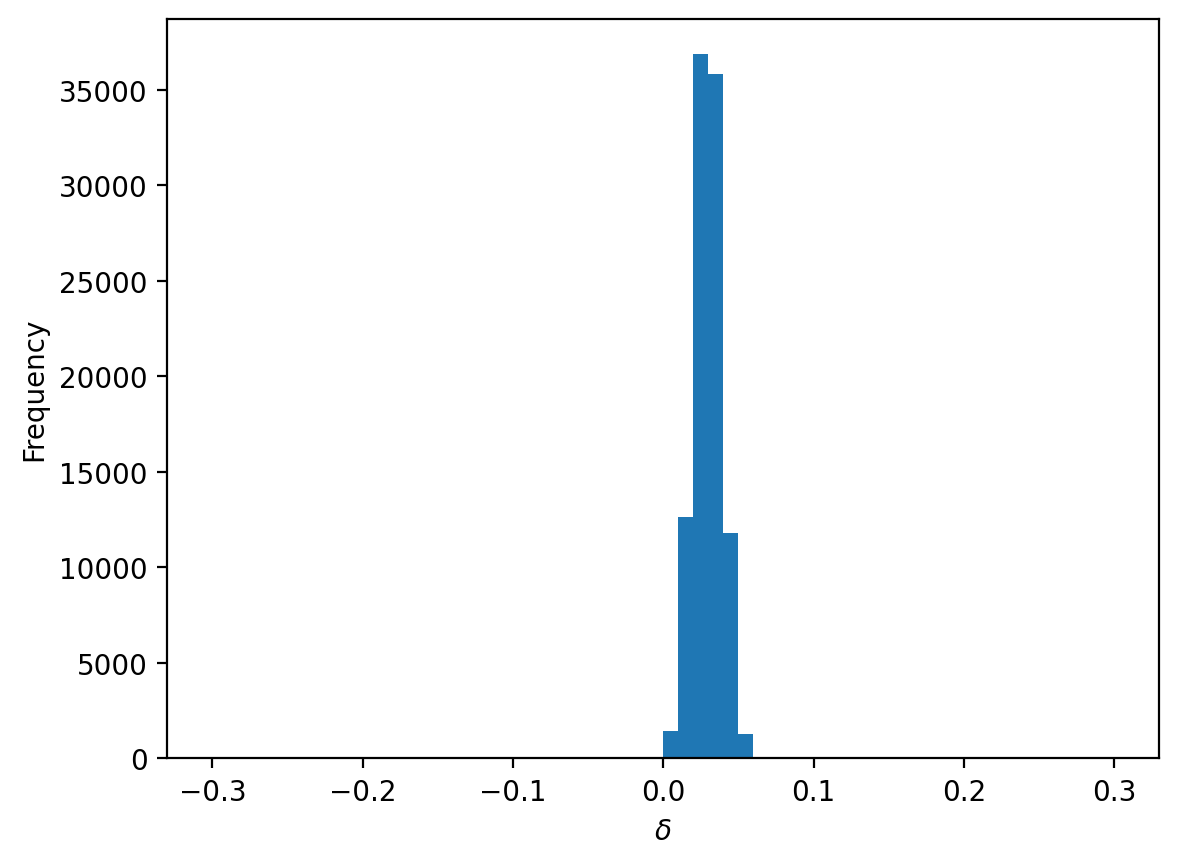

In [31]:
theta_a = np.random.beta(65, 1217, size=100000)
theta_b = np.random.beta(129, 1473, size=100000)
delta = theta_b - theta_a
plt.hist(delta, range=(-0.3, 0.3), bins=60)
plt.xlabel(r'$\delta$')
plt.ylabel('Frequency')
plt.show()

In [32]:
print((delta > 0).mean())

0.99946


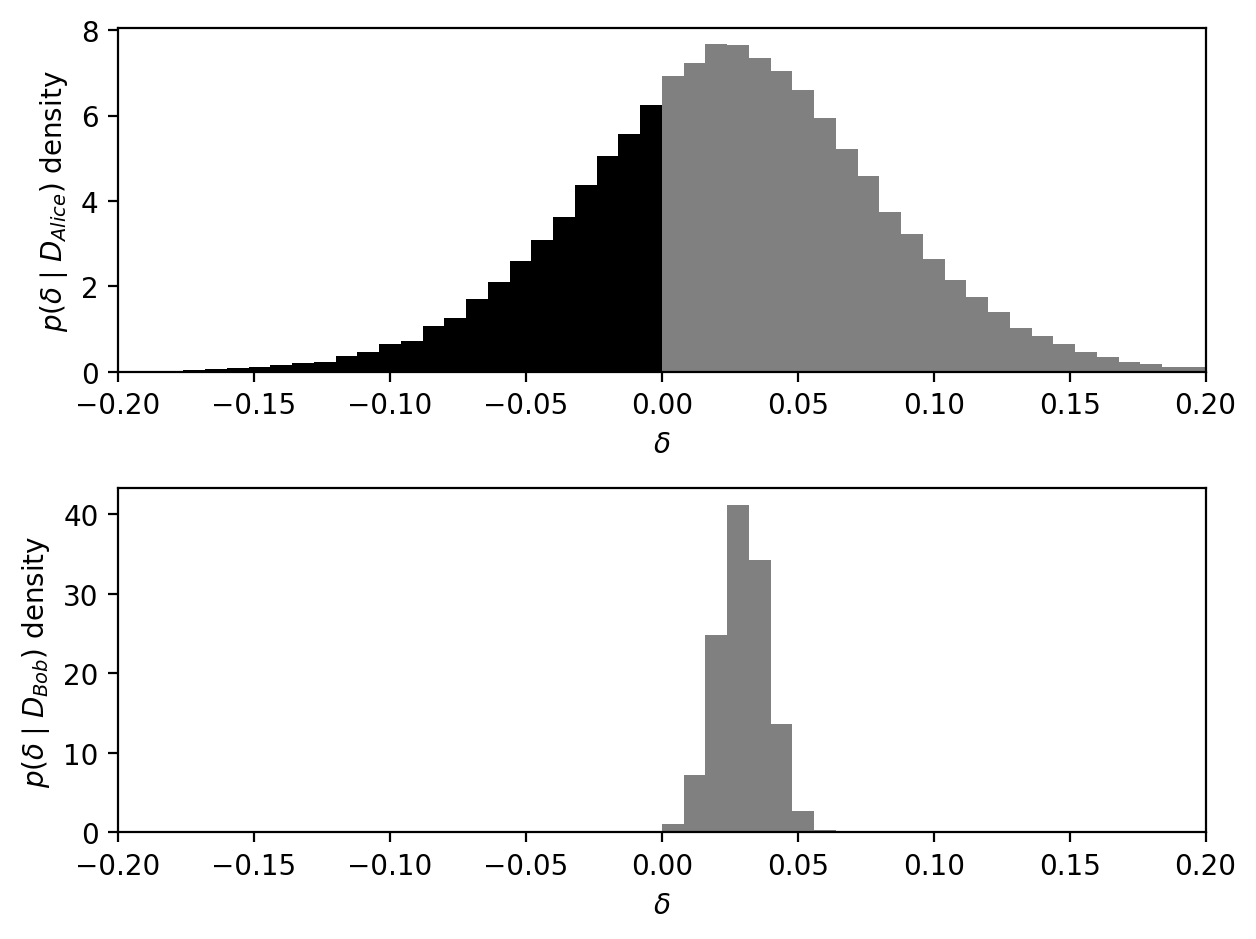

In [33]:
plt.subplot(2, 1, 1)
alice_a = np.random.beta(3, 39, size=100000)
alice_b = np.random.beta(5, 47, size=100000)
alice_delta = alice_b - alice_a
N, bins, patches = plt.hist(alice_delta, bins=50, range=(-0.2, 0.2), density=1, color='gray')
for i in np.where(bins < 0)[0]:
  patches[i].set_facecolor('black')
plt.xlim(-0.2, 0.2)
plt.xlabel(r'$\delta$')
plt.ylabel(r'$p(\delta\mid D_{Alice})$ density')

plt.subplot(2, 1, 2)
bob_a = np.random.beta(65, 1217, size=100000)
bob_b = np.random.beta(129, 1473, size=100000)
bob_delta = bob_b - bob_a
N, bins, patches = plt.hist(bob_delta, bins=50, range=(-0.2, 0.2), density=1,color='gray')
for i in np.where(bins < 0)[0]:
  patches[i].set_facecolor('black')
plt.xlim(-0.2, 0.2)
plt.xlabel(r'$\delta$')
plt.ylabel(r'$p(\delta\mid D_{Bob})$ density')
plt.tight_layout()